In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from pydts.utils import get_expanded_df
from tqdm import tqdm
from time import time
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from lifelines.fitters.coxph_fitter import CoxPHFitter
from scipy.special import expit
from scipy.optimize import minimize
import sys
sys.path.append('../')
sys.path.append('../../')
from examples.generate_simulations_data import generate_quick_start_df

In [2]:
n_cov = 5
patients_df = generate_quick_start_df(n_patients=10000, n_cov=n_cov, d_times=30, j_events=2, pid_col='pid', 
                                      seed=0)
covariates = [f'Z{i + 1}' for i in range(n_cov)]

train_df, test_df = train_test_split(patients_df, test_size=0.25)
events = sorted(train_df['J'].unique())
times = sorted(train_df['X'].unique())
train_df.head()  

,pid,Z1,Z2,Z3,Z4,Z5,T,C,X,J
829,829,0.414015,0.522616,0.824062,0.722130,0.501265,12.0,20,12.0,2
6526,6526,0.126134,0.494694,0.881525,0.864381,0.456955,4.0,9,4.0,2
733,733,0.505192,0.195869,0.144727,0.489497,0.779391,15.0,28,15.0,1
8721,8721,0.132330,0.866239,0.157450,0.829406,0.376125,4.0,17,4.0,2
8297,8297,0.518501,0.825034,0.323307,0.325517,0.874571,16.0,16,16.0,2


# Lee et al. 2018

In [3]:
expanded_train_df = get_expanded_df(train_df)
print(expanded_train_df.shape)
expanded_train_df

(76782, 13)


,pid,Z1,Z2,Z3,Z4,Z5,T,C,X,J,j_0,j_1,j_2
0,829,0.414015,0.522616,0.824062,0.722130,0.501265,12.0,20,1,2,1.0,0.0,0.0
1,829,0.414015,0.522616,0.824062,0.722130,0.501265,12.0,20,2,2,1.0,0.0,0.0
2,829,0.414015,0.522616,0.824062,0.722130,0.501265,12.0,20,3,2,1.0,0.0,0.0
3,829,0.414015,0.522616,0.824062,0.722130,0.501265,12.0,20,4,2,1.0,0.0,0.0
4,829,0.414015,0.522616,0.824062,0.722130,0.501265,12.0,20,5,2,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
76777,1295,0.362786,0.679557,0.810666,0.830425,0.805776,11.0,5,1,0,1.0,0.0,0.0
76778,1295,0.362786,0.679557,0.810666,0.830425,0.805776,11.0,5,2,0,1.0,0.0,0.0
76779,1295,0.362786,0.679557,0.810666,0.830425,0.805776,11.0,5,3,0,1.0,0.0,0.0
76780,1295,0.362786,0.679557,0.810666,0.830425,0.805776,11.0,5,4,0,1.0,0.0,0.0


In [4]:
expanded_train_df = pd.concat([expanded_train_df, 
                               pd.get_dummies(expanded_train_df['X'], prefix='alpha')], axis=1)
expanded_train_df

,pid,Z1,Z2,Z3,Z4,Z5,T,C,X,J,...,alpha_21,alpha_22,alpha_23,alpha_24,alpha_25,alpha_26,alpha_27,alpha_28,alpha_29,alpha_30
0,829,0.414015,0.522616,0.824062,0.722130,0.501265,12.0,20,1,2,...,0,0,0,0,0,0,0,0,0,0
1,829,0.414015,0.522616,0.824062,0.722130,0.501265,12.0,20,2,2,...,0,0,0,0,0,0,0,0,0,0
2,829,0.414015,0.522616,0.824062,0.722130,0.501265,12.0,20,3,2,...,0,0,0,0,0,0,0,0,0,0
3,829,0.414015,0.522616,0.824062,0.722130,0.501265,12.0,20,4,2,...,0,0,0,0,0,0,0,0,0,0
4,829,0.414015,0.522616,0.824062,0.722130,0.501265,12.0,20,5,2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76777,1295,0.362786,0.679557,0.810666,0.830425,0.805776,11.0,5,1,0,...,0,0,0,0,0,0,0,0,0,0
76778,1295,0.362786,0.679557,0.810666,0.830425,0.805776,11.0,5,2,0,...,0,0,0,0,0,0,0,0,0,0
76779,1295,0.362786,0.679557,0.810666,0.830425,0.805776,11.0,5,3,0,...,0,0,0,0,0,0,0,0,0,0
76780,1295,0.362786,0.679557,0.810666,0.830425,0.805776,11.0,5,4,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
alpha_list = [col for col in expanded_train_df.columns if col[:5] == 'alpha']
models = {}

In [6]:
start = time()

for e in tqdm(events[1:], total=len(events)-1):
    model = LogisticRegression()
    X, y =  expanded_train_df[covariates + alpha_list].values, expanded_train_df[f'j_{e}'].values
    model.fit(X, y)
    models[e] = model

end = time()

  0%|                                                                                                                                                 | 0/2 [00:00<?, ?it/s]/home/tomer/.cache/pypoetry/virtualenvs/pydts-XKR_9q43-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 50%|████████████████████████████████████████████████████████████████████▌                                                                    | 1/2 [00:01<00:01,  1.49s/it]/home/tomer/.cache/pypoetry/virtualenvs/pydts-XKR_9q43-py3.8/lib/python3.8/site-packages/sklearn

In [7]:
print(f'Total training time: {end - start:.2f} seconds')

Total training time: 2.94 seconds


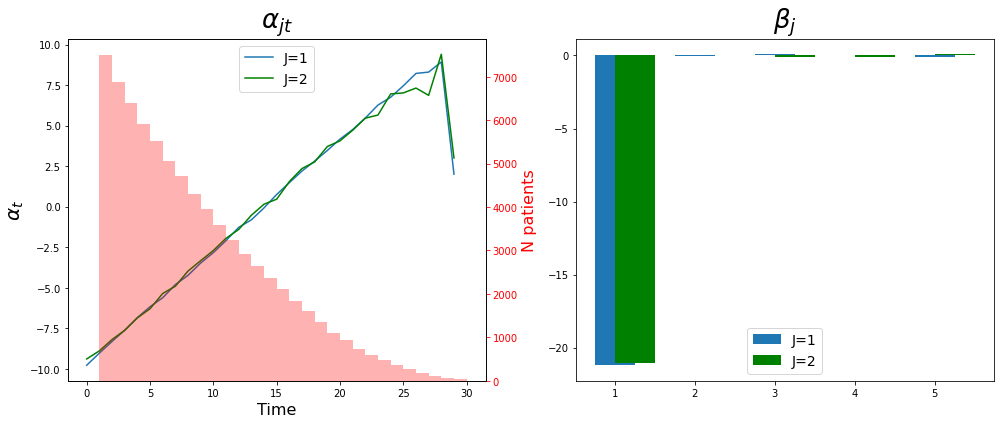

In [8]:
fig, axes = plt.subplots(1,2, figsize=(14,6))
ax = axes[0]
ax.set_title(r'$\alpha_{jt}$', fontsize=26)
ax.plot(models[1].coef_[0, n_cov:], label='J=1')
ax.plot(models[2].coef_[0, n_cov:], color='g', label='J=2')
ax.set_xlabel(r'Time', fontsize=16)
ax.set_ylabel(r'$\alpha_{t}$', fontsize=20)
ax.legend(loc='upper center', fontsize=14)
ax2 = ax.twinx()
ax2.hist(expanded_train_df['X'], color='r', alpha=0.3, bins=times)
ax2.set_ylabel('N patients', fontsize=16, color='red')
ax2.tick_params(axis='y', colors='red')

ax = axes[1]
ax.set_title(r'$\beta_{j}$', fontsize=26)
ax.bar(np.arange(1, n_cov+1), models[1].coef_[0, :n_cov], label='J=1', width=0.5)
ax.bar(np.arange(1, n_cov+1), models[2].coef_[0, :n_cov], color='g', label='J=2', align='edge', width=0.5)
ax.legend(loc='lower center', fontsize=14)

fig.tight_layout()

In [9]:
# test mse

# New approach

In [10]:
beta_models = {}

for e in events[1:]:
    strata_df = expanded_train_df[covariates + [f'j_{e}', 'X']].copy()
    strata_df['X_copy'] = expanded_train_df['X']

    beta_j_cox = CoxPHFitter()
    beta_j_cox.fit(df=strata_df[covariates+ ['X', 'X_copy', f'j_{e}']], duration_col='X', event_col=f'j_{e}', 
                   strata='X_copy')
    beta_models[e] = beta_j_cox
    print(beta_j_cox.params_)

covariate
Z1   -63.412231
Z2    -0.032487
Z3     0.084248
Z4     0.061798
Z5    -0.167631
Name: coef, dtype: float64
covariate
Z1   -61.386540
Z2     0.013896
Z3    -0.094727
Z4    -0.064984
Z5     0.042776
Name: coef, dtype: float64


Going back to the unexpanded data: 

In [11]:
train_df.head()

,pid,Z1,Z2,Z3,Z4,Z5,T,C,X,J
829,829,0.414015,0.522616,0.824062,0.722130,0.501265,12.0,20,12.0,2
6526,6526,0.126134,0.494694,0.881525,0.864381,0.456955,4.0,9,4.0,2
733,733,0.505192,0.195869,0.144727,0.489497,0.779391,15.0,28,15.0,1
8721,8721,0.132330,0.866239,0.157450,0.829406,0.376125,4.0,17,4.0,2
8297,8297,0.518501,0.825034,0.323307,0.325517,0.874571,16.0,16,16.0,2


In [12]:
y_t = len(train_df['X']) - train_df['X'].value_counts().sort_index().cumsum()
y_t.head()

1.0    6871
2.0    6387
3.0    5912
4.0    5513
5.0    5067
Name: X, dtype: int64

In [13]:
n_jt = train_df.groupby(['J', 'X']).size().to_frame().reset_index()
n_jt.columns = ['J', 'X' ,'n_jt']
n_jt.head()

,J,X,n_jt
0,0,1.0,244
1,0,2.0,219
2,0,3.0,228
3,0,4.0,183
4,0,5.0,219


In [14]:
def alpha_jt(x, df, y_t, beta_j, n_jt, t, duration_col='X' ):
    partial_df = df[df[duration_col] >= t]
    expit_add = (partial_df[covariates]*beta_j).sum(axis=1)
    return ((1/y_t)*np.sum(expit(x+expit_add)) - (n_jt/y_t))**2

In [15]:
x0 = 0

In [16]:
alpha_df = pd.DataFrame()
for e in events[1:]:
    n_et = n_jt[n_jt['J'] == e]
    n_et['opt_res'] = n_et.apply(lambda row: minimize(alpha_jt, x0, 
        args=(train_df, y_t.loc[row['X']], beta_models[e].params_,  row['n_jt'],  row['X'])), axis=1)
    n_et['success'] = n_et['opt_res'].apply(lambda val: val.success)
    n_et['alpha_jt'] = n_et['opt_res'].apply(lambda val: val.x[0])
    alpha_df = alpha_df.append(n_et, ignore_index=True)
alpha_df

/tmp/ipykernel_3485/2215661012.py:4: RuntimeWarning: divide by zero encountered in long_scalars
  return ((1/y_t)*np.sum(expit(x+expit_add)) - (n_jt/y_t))**2
/tmp/ipykernel_3485/2215661012.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  return ((1/y_t)*np.sum(expit(x+expit_add)) - (n_jt/y_t))**2
/tmp/ipykernel_3485/2215661012.py:4: RuntimeWarning: invalid value encountered in double_scalars
  return ((1/y_t)*np.sum(expit(x+expit_add)) - (n_jt/y_t))**2
/tmp/ipykernel_3485/2215661012.py:4: RuntimeWarning: divide by zero encountered in long_scalars
  return ((1/y_t)*np.sum(expit(x+expit_add)) - (n_jt/y_t))**2
/tmp/ipykernel_3485/2215661012.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  return ((1/y_t)*np.sum(expit(x+expit_add)) - (n_jt/y_t))**2
/tmp/ipykernel_3485/2215661012.py:4: RuntimeWarning: invalid value encountered in double_scalars
  return ((1/y_t)*np.sum(expit(x+expit_add)) - (n_jt/y_t))**2
/tmp/ipykernel_3485/1221706489.py:4: SettingWi

,J,X,n_jt,opt_res,success,alpha_jt
0,1,1.0,174,"{'fun': 5.258840143354937e-18, 'jac': [-6.0285...",True,1.233614
1,1,2.0,133,"{'fun': 3.6668924524485476e-09, 'jac': [-1.520...",True,3.835301
2,1,3.0,125,"{'fun': 0.00044312434674739375, 'jac': [-3.902...",True,0.000000
3,1,4.0,115,"{'fun': 0.00043466400657560906, 'jac': [-4.663...",True,0.000000
4,1,5.0,121,"{'fun': 0.0005701808431330507, 'jac': [-7.3916...",True,0.000000
5,1,6.0,107,"{'fun': 0.0005171806081646748, 'jac': [-7.2250...",True,0.000000
6,1,7.0,94,"{'fun': 0.00047765669497794544, 'jac': [-1.047...",True,0.000000
7,1,8.0,97,"{'fun': 0.0006009125428927716, 'jac': [-1.3824...",True,0.000000
8,1,9.0,85,"{'fun': 0.0005615327427849712, 'jac': [-1.4551...",True,0.000000
9,1,10.0,85,"{'fun': 0.0006878278996754471, 'jac': [-1.4551...",True,0.000000
